# Mol2vec embbeding and spectra prediction of input molecules

LIBRARIES

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import math
import glob
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.5)

import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torchvision


#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
print(f'Using {DEVICE} device')

#Importing Chem module
from rdkit import Chem 
from rdkit import DataStructs
import gensim
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from gensim.models.callbacks import CallbackAny2Vec

Using cpu device


## 0. GENERAL DATA

Molecules to be predicted

In [2]:
file_input_mols = 'data/inputMols_git.xlsx'
dfMolecules = pd.read_excel(file_input_mols)
print(dfMolecules)

          smiles                name  \
0  CCC(=O)C(O)=O  2-Ketobutyric acid   

                                            spectrum  \
0  [27.0, 28.0, 29.0, 30.0, 31.0, 39.0, 40.0, 41....   

                                    link  
0  https://hmdb.ca/spectra/ms_ms/1473314  


Most frequented positions in the training dataset

In [3]:
#M/Z positions where we have models
pickle_in=open("data/modelData/AllMostFreqMolGeneral_rep_dades1.pickle", "rb")
dfMostFreq100=pickle.load(pickle_in)

In [4]:
#First 1000 m/z positions more frequented by peaks
posPeak1000=dfMostFreq100[0:1000].posPeak.tolist()

Mol2vec embedding model and functions

In [5]:
#Mol2vec model uploading
model = word2vec.Word2Vec.load('data/Mol2vecModel/Mol2vecModelGeneral_rep_dades1.model')

In [6]:
def finalVector(df_smiles_column):
    
    #Embedding dataframe
    dfSmilesEmb = pd.DataFrame()
    
    #Save the smiles
    print("step 1")
    dfSmilesEmb['smiles'] = df_smiles_column
    
    #Constructing sentences
    dfSmilesEmb['mol'] = df_smiles_column.apply(lambda x: Chem.MolFromSmiles(x)) 
    naMols = []
    for c,mol in enumerate(dfSmilesEmb.mol):
        if((mol == None)):
            naMols += [c]
    dfSmilesEmb = dfSmilesEmb.drop(dfSmilesEmb.index[naMols])
    dfSmilesEmb.reset_index(inplace=True, drop=True)
    
    print("step 2")
    col2 = dfSmilesEmb['mol'].copy()
    dfSmilesEmb['sentence'] = col2
    for count, value in enumerate(dfSmilesEmb['mol']):
        if value == None:
            dfSmilesEmb['sentence'][count]= None
        else:
            try:
                dfSmilesEmb['sentence'][count] = MolSentence(mol2alt_sentence(value, radius=1))
            except:
                dfSmilesEmb['sentence'][count] = None
    
    #DELETE THE MOLECULES THAT HAVE A "sentence"== None
    naMols = []
    for c,sentence in enumerate(dfSmilesEmb.sentence):
        if((sentence == None)):
            naMols += [c]
            
    dfSmilesEmb = dfSmilesEmb.drop(dfSmilesEmb.index[naMols])
    dfSmilesEmb.reset_index(inplace=True, drop=True)

    #Extracting embeddings to a numpy.array
    print("step 3")
    col2 = dfSmilesEmb['sentence'].copy()
    dfSmilesEmb['mol2vec'] = col2
    for c,x in enumerate(sentences2vec(dfSmilesEmb['sentence'], model)):
        if (type(x) != int):
            try:
                dfSmilesEmb['mol2vec'][c] = DfVec(x)
            except:
                dfSmilesEmb['mol2vec'][c] = None
        else:
            dfSmilesEmb['mol2vec'][c] = None
            
    naMols = []
    for c,sentence in enumerate(dfSmilesEmb.mol2vec):
        if((sentence == None)):
            naMols += [c]
            
    dfSmilesEmb = dfSmilesEmb.drop(dfSmilesEmb.index[naMols])
    dfSmilesEmb.reset_index(inplace=True, drop=True)
    
    print("step 4")
    Molvectors = np.array([x.vec for x in dfSmilesEmb['mol2vec']])
    
    #Add the results to the dataframe
    print("step 5")
    dfSmilesEmb['FinalVec']=list(Molvectors)
    
    return dfSmilesEmb

Models for peak prediction

In [7]:
BS = 16 
DEVICE = 'cpu'

In [8]:
# ANN
# The feedforward network class
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [9]:
# DATALOADER
def load_dataTest(datafr, device=DEVICE, bs=BS):
    
    vx1 = datafr.to_numpy() #convert dataframe column as a numpy type
    vx2 = np.vstack(vx1).astype(np.float32) #convert objects to numpy type from objecr to float

    # Validation set
    ds = TensorDataset(torch.from_numpy(vx2))
    test_dataloader = DataLoader(ds, batch_size=bs)
    return test_dataloader 

In [10]:
#Threshold to determine peak for each model
pickle_in=open("data/modelData/thresholdsANN.pickle", "rb")
dfThresholdVal=pickle.load(pickle_in)

In [11]:
#Open the ANN models
pickle_models = glob.glob('data/ANN/ModelVal*.pickle')

Peak prediction function

In [12]:
def mz_calculation2(dfThresholdVal, mz, dfResultsTest, moleculesDB):

    #Open the model threshold to decide peaks
    th2Final = float(dfThresholdVal.th[dfThresholdVal.mzPosition==mz])
    #Condition to add in the mz list the peak for the molecules that have a higher prediction
    peak_smiles = dfResultsTest.smiles[dfResultsTest["Prediction"]>=th2Final].tolist()
    #Index of the molecules that have this peak
    indexes_smiles = moleculesDB.index[moleculesDB.smiles.isin(peak_smiles)]
    for mol_val in indexes_smiles:
        moleculesDB['mz'][mol_val].append(mz)
        
    return moleculesDB

## 1. EMBEDDING CALCULATION OF PREVIOUS DATA

In [13]:
dfMolecules.head(1)

,smiles,name,spectrum,link
0,CCC(=O)C(O)=O,2-Ketobutyric acid,"[27.0, 28.0, 29.0, 30.0, 31.0, 39.0, 40.0, 41....",https://hmdb.ca/spectra/ms_ms/1473314


In case the input data set is very large, we have to divide it into smaller sets

In [3]:
#divide the dataset of molecules
# listDF = range(0, len(dfMolecules["smile"]), 100000)
# listDF = list(listDF)
# listDF = listDF + [len(dfMolecules["smile"])]

In [ ]:
#Select the range of molecules we sould like to compute
# dfMolecules = dfMolecules.iloc[posCount, posCount + 100000]

Calculation of the Mol2vec embedding:

In [14]:
datafr = dfMolecules.smiles #INPUT DATA (insert the smiles column of the dataframe)
dataTestR = finalVector(datafr) #EMBEDDING = dataTestR["FinalVec"]

step 1
step 2
step 3
step 4
step 5


Save in the previous dataframe the new Mol2vec embedding:

In [15]:
dataTestR.head(1)

,smiles,mol,sentence,mol2vec,FinalVec
0,CCC(=O)C(O)=O,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 206478835...","(300,) dimensional vector","[-0.7609567642211914, -0.1555800437927246, -1...."


In [16]:
dfMolecules.head(1)

,smiles,name,spectrum,link
0,CCC(=O)C(O)=O,2-Ketobutyric acid,"[27.0, 28.0, 29.0, 30.0, 31.0, 39.0, 40.0, 41....",https://hmdb.ca/spectra/ms_ms/1473314


In [17]:
dfMolecules = dfMolecules.merge(dataTestR, how='inner', on='smiles')
dfMolecules = dfMolecules.drop(columns=['mol', 'sentence', 'mol2vec'])

Calculate the spectra prediction:

In [18]:
#create a dataframe to put the results
dfResultsTest = pd.DataFrame() 

#Data set with the results
dataEmb = dfMolecules.FinalVec

for cp, peak in enumerate(pickle_models): 

    dfPeakPreds = pd.DataFrame() 
    position = []
    zeros = []

    #mz:
    namePickle = peak
    namePickle = re.sub("data/ANN/ModelVal","",namePickle)
    namePickle = re.sub(".pickle","",namePickle)
    mz = int(namePickle)

    if mz in posPeak1000: #in 1000 most common positions

        zeros += [mz]
        position += [mz]

        #Open pickle models
        pickle_in = open(peak, "rb")
        model = pickle.load(pickle_in) #dataframe for one mz position

        test_dataloader = load_dataTest(datafr = dataEmb)
        pred_test = model(test_dataloader.dataset.tensors[0].to(DEVICE))
        pred = pred_test.cpu().detach().numpy()
        dfResultsTest["Prediction"] = pred.tolist()
        
        #Loop to save the prediction
        for cont, i in enumerate(dfResultsTest["Prediction"]):
            p= str(i)[1:-1] #take off the brakets 
            dfResultsTest["Prediction"][cont]=float(p)

        #Save the smiles per predictions
        dfResultsTest["smiles"] = dfMolecules.smiles

        #Save the predictions per peak in a pickle:
        pickle_out=open("results/dfPredictionPeak_{}.pickle".format(mz), "wb")
        pickle.dump(dataTestR, pickle_out)
        pickle_out.close()

    #Initialization of an empty dataframe with canonical smiles to save the peaks
    if (cp == 0):
        moleculesDB = pd.DataFrame()
        moleculesDB["smiles"] = dfMolecules.smiles
        #Addition of an empty column for the spectra
        moleculesDB['mz'] = np.empty((len(moleculesDB), 0)).tolist()

    #MZ function calculation
    moleculesDB = mz_calculation2(dfThresholdVal, mz, dfResultsTest, moleculesDB)

In [19]:
display(moleculesDB)

,smiles,mz
0,CCC(=O)C(O)=O,"[5704, 4303]"


In [20]:
display(dfMolecules)

,smiles,name,spectrum,link,FinalVec
0,CCC(=O)C(O)=O,2-Ketobutyric acid,"[27.0, 28.0, 29.0, 30.0, 31.0, 39.0, 40.0, 41....",https://hmdb.ca/spectra/ms_ms/1473314,"[-0.7609567642211914, -0.1555800437927246, -1...."


Add predicted to the molecules from the last dataset their respective spectrum:

In [21]:
dfMolecules_2 = dfMolecules.merge(moleculesDB, how='inner', on='smiles')

In [22]:
display(dfMolecules_2)

,smiles,name,spectrum,link,FinalVec,mz
0,CCC(=O)C(O)=O,2-Ketobutyric acid,"[27.0, 28.0, 29.0, 30.0, 31.0, 39.0, 40.0, 41....",https://hmdb.ca/spectra/ms_ms/1473314,"[-0.7609567642211914, -0.1555800437927246, -1....","[5704, 4303]"


In [23]:
(dfMolecules_2.spectrum[0])

'[27.0, 28.0, 29.0, 30.0, 31.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 55.0, 56.0, 57.0, 85.0, 103.0]'

Save all the data in a .json file:

In [24]:
#Save the data in a .json file
moleculesDB.to_json(r'results/predSpectra.json')

## 2. SPECTRA RECONSTRUCTION

### 2.1. Comparison of the real spectrum with the predicted

Binarization of the input spectra

In [25]:
#Convert the spectrum values to floats
for val, spectrum in enumerate(dfMolecules_2['spectrum']):
    spectrumString = spectrum.replace('[', '')
    spectrumString = spectrumString.replace(']', '')
    spectrumString = spectrumString.split(',')
    spectrumFloats = [float(i) for i in spectrumString]
    dfMolecules_2['spectrum'][val] = spectrumFloats

In [26]:
# Look for the max mz value
mZ = []
for listPeaks in dfMolecules_2['spectrum']:
    mZ += [max(listPeaks)]
max_mz = max(mZ)
min_mz = 0

In [27]:
max_mz

103.0

In [28]:
#Discretize mz of the spectra (bin = 0.01)
min_mz = 0
bins = np.arange(min_mz, max_mz + 0.01, 0.01) #bins from 0 to max_mz (5994)
print(len(bins))
print(max_mz)

10301
103.0


In [29]:
binsMZ100 = range(0,len(bins)+1)

In [30]:
#Loop to save in a vector the mz positions where the molecules present peak
ListBins=[]
for con,listMZ in enumerate(dfMolecules_2['spectrum']):   #list per raw
    values = np.digitize(listMZ, bins)
    ListBins += [values]
dfMolecules_2['BinarSpectrum'] = ListBins

In [31]:
#MZ positions where we have model
maxModels = 1000
positionMZ = dfMostFreq100.mz[0:maxModels].tolist()
positionMZ.sort()
modelMZ = dfMostFreq100.posPeak[0:maxModels].tolist()
modelMZ.sort()
#Limit values to 2 decimals
positionMZ = [ float("{:.2f}".format(mz)) for mz in positionMZ ]
print(modelMZ)

[2904, 3903, 4104, 4105, 4204, 4302, 4303, 4306, 4405, 4406, 4504, 5002, 5101, 5103, 5202, 5203, 5204, 5301, 5302, 5303, 5304, 5305, 5404, 5405, 5502, 5503, 5505, 5506, 5594, 5602, 5605, 5606, 5697, 5698, 5702, 5704, 5705, 5706, 5707, 5708, 5799, 5803, 5807, 5900, 5903, 5905, 6000, 6005, 6101, 6102, 6103, 6198, 6202, 6303, 6402, 6403, 6404, 6501, 6502, 6503, 6504, 6505, 6601, 6603, 6604, 6605, 6702, 6703, 6705, 6706, 6802, 6803, 6804, 6805, 6806, 6898, 6900, 6901, 6902, 6904, 6905, 6906, 6907, 6908, 6999, 7003, 7007, 7100, 7102, 7105, 7106, 7107, 7109, 7205, 7209, 7294, 7299, 7303, 7307, 7402, 7501, 7502, 7503, 7602, 7603, 7604, 7701, 7702, 7703, 7704, 7705, 7804, 7805, 7902, 7903, 7905, 7906, 8002, 8003, 8005, 8006, 8007, 8102, 8104, 8105, 8106, 8107, 8108, 8199, 8203, 8204, 8205, 8206, 8207, 8208, 8300, 8302, 8303, 8305, 8306, 8307, 8309, 8405, 8409, 8499, 8502, 8503, 8504, 8507, 8511, 8602, 8606, 8607, 8610, 8703, 8705, 8802, 8804, 8808, 8903, 8904, 9004, 9005, 9102, 9105, 9106, 920

In [32]:
def spectrumReconstructionComparison(ax, positionMZ, realSpec, predSpec, colorReal1, colorReal2, colorPred):

    #Divide values /100
    realSpec2 = [ float("{:.2f}".format(mz/100)) for mz in realSpec ]
    predSpec2 = [ float("{:.2f}".format(mz/100)) for mz in predSpec ]
    
    #Represent prediction peaks
    for pos, mz in enumerate(realSpec2):
        xpoints = np.array([mz, mz])
        ypoints = np.array([0, 1])

        if mz in positionMZ: #if we have model to predict this peak
            if (pos == (len(realSpec2)-1)):
                ax.plot(xpoints, ypoints, color = colorReal1,  label='Real spectra where model', linewidth=1)
            else:
                ax.plot(xpoints, ypoints, color = colorReal1, linewidth=1)
        else: 
            if (pos == (len(realSpec2)-1)):
                ax.plot(xpoints, ypoints, color = colorReal2,  label='Real spectra where no model', linewidth=1)
            else:
                ax.plot(xpoints, ypoints, color = colorReal2, linewidth=1)
                
    #Represent solution peaks
    for pos, mz in enumerate(predSpec2):
        xpoints = np.array([mz, mz])
        ypoints = np.array([0, -1])
        if (pos == (len(predSpec2)-1)):
            ax.plot(xpoints, ypoints, color = colorPred,  label='PREDICTION', linewidth=1)
        else:
            ax.plot(xpoints, ypoints, color = colorPred, linewidth=1)

In [35]:
zerosY = np.zeros((len(positionMZ),), dtype=int)
spectrum_real = dfMolecules_2.BinarSpectrum[0]
spectrum_pred = dfMolecules_2.mz[0]

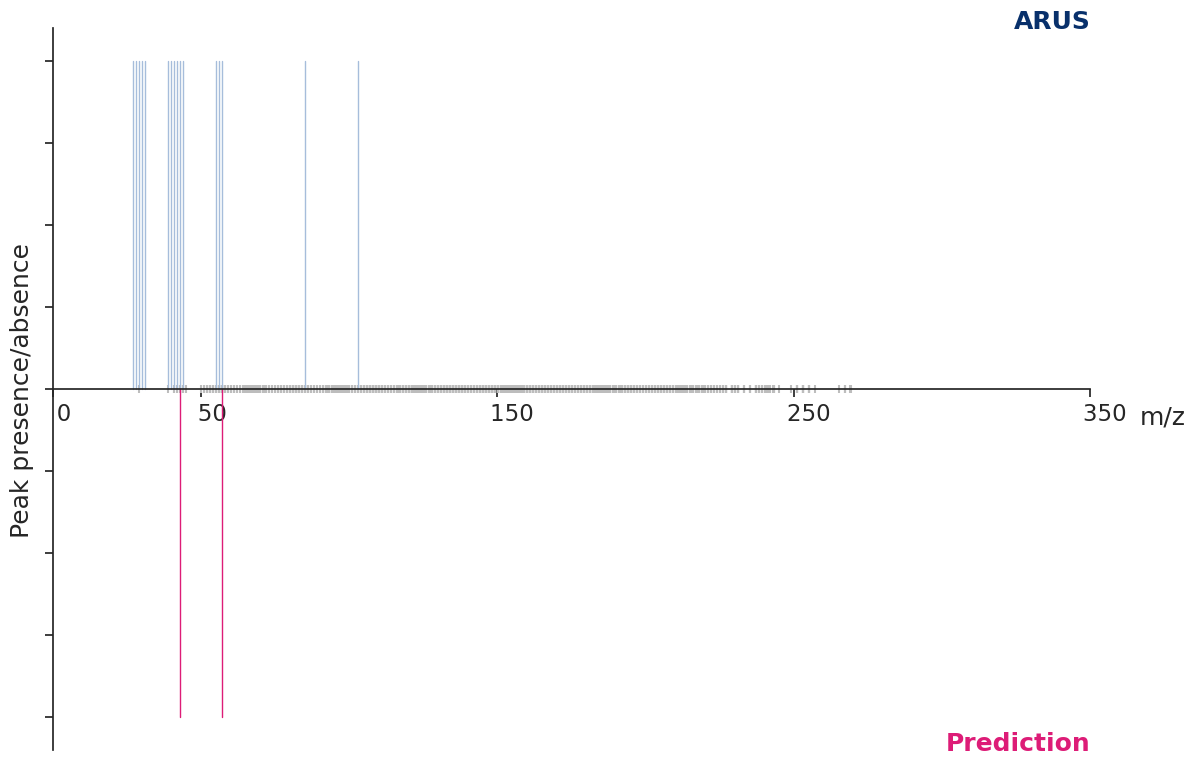

In [53]:
plt.close('all')
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

#Add a grey line in every m/z position where we have a trained model
ax1.scatter(x= positionMZ, y = zerosY, marker='|', color = "#bdbdbd")            
#We paint the peaks from the experimental spectrum in light blue if we don't have a model that can predict them, and in dark blue if we do have a model. 
spectrumReconstructionComparison(ax1, positionMZ, spectrum_real, spectrum_pred, colorReal1 = "#08306b", colorReal2 = "#a6bddb", colorPred = "#dd1c77")
ax1.text(1,1,  'ARUS',  fontsize= 18, fontweight = 'bold', color = "#08306b", horizontalalignment='right',  transform=ax1.transAxes)
ax1.text(1,0, 'Prediction',  fontsize= 18, fontweight = 'bold', color = "#dd1c77", horizontalalignment='right',  transform=ax1.transAxes)
ax1.set(yticklabels=[]) 
ax1.set_ylabel('Peak presence/absence')
ax1.spines['bottom'].set_position('center')
ax1.set_xticks([0, 50, 150, 250, 350])
ax1.set_xticklabels(['   0', '   50','    150', '    250', '    350'])
ax1.set_xlabel('m/z', x= 1.07, labelpad = -15)

sns.despine()
plt.tight_layout()
plt.show()